### Statistical Method (AR & ARIMA)

### From scratch

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax as sm

In [224]:
file = "../datasets/clean/df_41017.csv"
df = pd.read_csv(file, index_col=0)
df.index = pd.to_datetime(df.index)

In [225]:
train = df[df.index < pd.to_datetime("2016/01/01")]
test = df[df.index > pd.to_datetime("2016/01/01")]
print(f"Train: {train.shape}\nTest: {test.shape}")

Train: (24121, 1)
Test: (8783, 1)


In [246]:
class AutoRegressive:
    
    def __init__(self, p, df):
        self.p = p
        self.df = df
        
        df_temp = self.df
        
        for lag in range(1, self.p+1):
            df_temp[f"Shifted_values_{lag}"] = df_temp.swh.shift(lag)

        self.train = df_temp[df_temp.index < pd.to_datetime("2016/01/01")]
        self.test = df_temp[df_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, self.p)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
    
    def predict(self, steps=100):
        self.steps = steps
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.X_train.dot(self.theta) + self.intercept
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,self.p)
        
        self.test['Predicted Values'] = self.X_test.dot(self.theta) + self.intercept
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.p} lags.")
        print(f"MAE: {self.MAE} with {self.p} lags")
        
        self.prediction = pd.DataFrame([self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Actual', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.RMSE, self.MAE
    
    
    def get_all_residuals(self):
        train_residuals = pd.DataFrame([self.train['swh'], self.train['Predicted Values'], self.train['swh'].values - self.train['Predicted Values']]).T
        train_residuals.columns = ['Actual', 'Predicted', 'Residuals']
        test_residuals = self.prediction
        test_residuals['Residuals'] = self.prediction['Actual'] - self.prediction['Predicted']
        test_residuals.index = self.test.index[:len(self.prediction)]
        self.residuals = pd.concat([train_residuals, test_residuals])
        
        return self.residuals
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Actual.values, label='Actual')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('Autoregressive')
        plt.legend()
        plt.show()
        
        
    def plot_residuals(self):
        residuals = pd.DataFrame(self.prediction['Actual'] - self.prediction['Predicted'])
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(residuals)
        ax1.set_title("residual line plot")
        ax2 = sns.distplot(residuals)
        ax2.set_title("residual density plot")
        plt.show()
        print("Statistics:")
        print(residuals.describe())

        

class MA:
    
    def __init__(self, q, residuals):
        self.q = q
        self.residuals = residuals
        
        residuals_temp = self.residuals
                
        for lag in range(1, self.q+1):
            residuals_temp[f"Shifted_values_{lag}"] = residuals_temp.Residuals.shift(lag)

        self.train = residuals_temp[residuals_temp.index < pd.to_datetime("2016/01/01")]
        self.test = residuals_temp[residuals_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, self.q)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        
    def predict(self, steps=None):
        if steps is None:
            steps = self.test
        try:
            if steps > len(self.test):
                raise ValueError(f'Maximum steps are {len(self.test)}.')
            else:
                self.steps = steps
        except ValueError as error:
            print(f'Value must be integer and the maximum steps are {len(self.test)} steps.')
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.X_train.dot(self.theta) + self.intercept
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,self.q)
        
        self.test['Predicted Values'] = self.X_test.dot(self.theta) + self.intercept
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.q} lags.")
        print(f"MAE: {self.MAE} with {self.q} lags.")
        
        self.prediction = pd.DataFrame([self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Residuals', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.RMSE, self.MAE
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Residuals.values, label='Residuals')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('MA')
        plt.legend()
        plt.show()
        

        
class AutoRegressiveSeasonality:
    
    def __init__(self, P, df, s):
        self.P = P
        self.s = s
        
        df_temp = df
        
        shifts_P = set()
        temp_P = P
        for i in range(self.s,self.s+self.P):
            shifts_P.add(i)
            for j in range(self.s*temp_P, self.s*temp_P+self.P):
                shifts_P.add(j)
            if temp_P != 1:
                temp_P -= 1
            else:
                break
                
        for lag in list(shifts_P):
            df_temp[f"Shifted_values_{lag}"] = df_temp.swh.shift(lag)

        self.train = df_temp[df_temp.index < pd.to_datetime("2016/01/01")]
        self.train = self.train.reindex([self.train.columns[0]] + sorted(self.train.columns[1:]), axis=1)
        self.test = df_temp[df_temp.index > pd.to_datetime("2016/01/01")]
        self.test = self.test.reindex([self.test.columns[0]] + sorted(self.test.columns[1:]), axis=1)
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, len(self.train.columns)-1)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)

             
    def predict(self, steps=100):
        self.steps = steps
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.X_train.dot(self.theta) + self.intercept
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,len(self.test.columns)-1)
        
        self.test['Predicted Values'] = self.X_test.dot(self.theta) + self.intercept
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.P} seasonal lags.")
        print(f"MAE: {self.MAE} with {self.P} seasonal lags.")
        
        self.prediction = pd.DataFrame([self.test['swh'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Actual', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.RMSE, self.MAE
    
    
    def get_all_residuals(self):
        train_residuals = pd.DataFrame([self.train['swh'], self.train['Predicted Values'], self.train['swh'].values - self.train['Predicted Values']]).T
        train_residuals.columns = ['Actual', 'Predicted', 'Residuals']
        test_residuals = self.prediction
        test_residuals['Residuals'] = self.prediction['Actual'] - self.prediction['Predicted']
        test_residuals.index = self.test.index[:len(self.prediction)]
        self.residuals = pd.concat([train_residuals, test_residuals])
        
        return self.residuals
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Actual.values, label='Actual')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('Autoregressive Seasonality')
        plt.legend()
        plt.show()
    
    
    def plot_residuals(self):
        residuals = pd.DataFrame(self.prediction['Actual'] - self.prediction['Predicted'])
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(residuals)
        ax1.set_title("residual line plot")
        ax2 = sns.distplot(residuals)
        ax2.set_title("residual density plot")
        plt.show()
        print("Statistics:")
        print(residuals.describe())
        

        
class MASeasonality:
    
    def __init__(self, q, Q, residuals, s):
        self.Q = Q
        self.s = s
        self.q = q
        
        self.residuals_temp = residuals
        
        shifts_Q = set()

        for i in range(self.s, self.s+q+1):
            shifts_Q.add(i)
            for j in range(self.s*self.Q, self.s*self.Q+q+1):
                shifts_Q.add(j)
        
        for lag in list(shifts_Q):
            self.residuals_temp[f"Shifted_values_{lag}"] = self.residuals_temp.Residuals.shift(lag)

        self.train = self.residuals_temp[self.residuals_temp.index < pd.to_datetime("2016/01/01")]
        self.test = self.residuals_temp[self.residuals_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        self.X_train = self.train.iloc[:, 1:].values.reshape(-1, len(self.train.columns)-1)
        self.y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        
    def predict(self, steps=None):
        if steps is None:
            steps = self.test
        try:
            if steps > len(self.test):
                raise ValueError(f'Maximum steps are {len(self.test)}.')
            else:
                self.steps = steps
        except ValueError as error:
            print(f'Value must be integer and the maximum steps are {len(self.test)} steps.')
        
        LR = LinearRegression()
        LR.fit(self.X_train, self.y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = self.X_train.dot(self.theta) + self.intercept
        
        self.X_test = self.test.iloc[:, 1:].values.reshape(-1,len(self.test.columns)-1)
        
        self.test['Predicted Values'] = self.X_test.dot(self.theta) + self.intercept
        
        self.RMSE = np.sqrt(mean_squared_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values))
        self.MAE = mean_absolute_error(self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"RMSE: {self.RMSE} with {self.Q} seasonal lags.")
        print(f"MAE: {self.MAE} with {self.Q} seasonal lags.")
        
        self.prediction = pd.DataFrame([self.test['Residuals'][:self.steps].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Residuals', 'Predicted']
        self.prediction.index = self.test.index[:self.steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_metrics(self):
        return self.MAE
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Residuals.values, label='Residuals')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('MA Seasonality')
        plt.legend()
        plt.show()

#### AR

In [227]:
df2 = df.copy()
p, d, q = 2, 0, 2
autoregressive = AutoRegressive(p, df2)
autoregressive_pred = autoregressive.predict()
autoregressive_metrics = autoregressive.get_metrics()

RMSE: 0.13789742402408647 with 2 lags.
MAE: 0.10378346554249607 with 2 lags


In [228]:
autoregressive_pred.head()

,Actual,Predicted
date,,
2016-01-01 00:50:00,2.59,2.556465
2016-01-01 01:50:00,2.71,2.595562
2016-01-01 02:50:00,2.88,2.647426
2016-01-01 03:50:00,2.83,2.793788
2016-01-01 04:50:00,3.11,2.835438


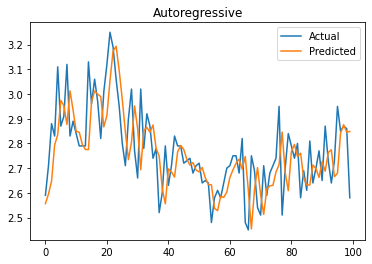

In [229]:
autoregressive.plot_predict()

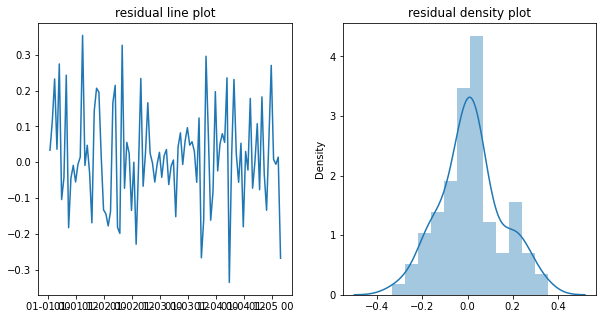

Statistics:
                0
count  100.000000
mean     0.015265
std      0.137740
min     -0.336046
25%     -0.057828
50%      0.014316
75%      0.078075
max      0.354482


In [230]:
autoregressive.plot_residuals()

In [231]:
autoregressive_resid = autoregressive.get_all_residuals()
autoregressive_resid.head()

,Actual,Predicted,Residuals
date,,,
2013-04-01 01:50:00,2.32,2.163940,0.156060
2013-04-01 02:50:00,2.47,2.256079,0.213921
2013-04-01 03:50:00,2.31,2.399298,-0.089298
2013-04-01 04:50:00,2.37,2.370027,-0.000027
2013-04-01 05:50:00,2.25,2.338199,-0.088199


#### MA

In [232]:
ma_model = MA(q, autoregressive_resid[['Residuals']])
ma_pred = ma_model.predict(100)
ma_metrics = ma_model.get_metrics()

RMSE: 0.13423211602126253 with 2 lags.
MAE: 0.10366944396112723 with 2 lags.


In [233]:
ma_pred.head()

,Residuals,Predicted
date,,
2016-01-01 00:50:00,0.033535,0.006226
2016-01-01 01:50:00,0.114438,-0.023296
2016-01-01 02:50:00,0.232574,-0.014964
2016-01-01 03:50:00,0.036212,-0.037925
2016-01-01 04:50:00,0.274562,-0.040859


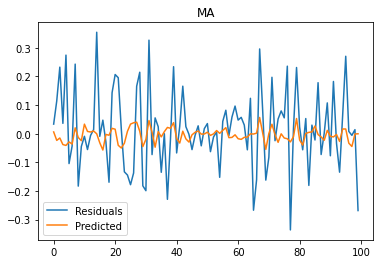

In [234]:
ma_model.plot_predict()

#### ARIMA

In [235]:
ARIMA_pred = autoregressive_pred['Predicted'] + ma_pred['Predicted'].values

In [236]:
ARIMA = pd.DataFrame([autoregressive_pred['Actual'].values,
                      ARIMA_pred,
                      autoregressive_pred['Actual'].values-ARIMA_pred]).T
ARIMA.columns = ['Actual', 'Predicted', 'Residuals']
ARIMA.index = autoregressive_pred.index

In [237]:
ARIMA.head()

,Actual,Predicted,Residuals
date,,,
2016-01-01 00:50:00,2.59,2.562691,0.027309
2016-01-01 01:50:00,2.71,2.572266,0.137734
2016-01-01 02:50:00,2.88,2.632462,0.247538
2016-01-01 03:50:00,2.83,2.755863,0.074137
2016-01-01 04:50:00,3.11,2.794580,0.315420


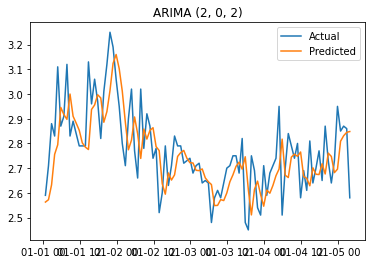

RMSE: 0.13423211602126253
MAE: 0.10366944396112723


In [238]:
plt.plot(ARIMA.Actual, label='Actual')
plt.plot(ARIMA.Predicted, label='Predicted')
plt.title(f'ARIMA ({p}, 0, {q})')
plt.legend()
plt.show()
print(f"RMSE: {np.sqrt(mean_squared_error(ARIMA.Actual, ARIMA.Predicted))}")
print(f"MAE: {mean_absolute_error(ARIMA.Actual, ARIMA.Predicted)}")

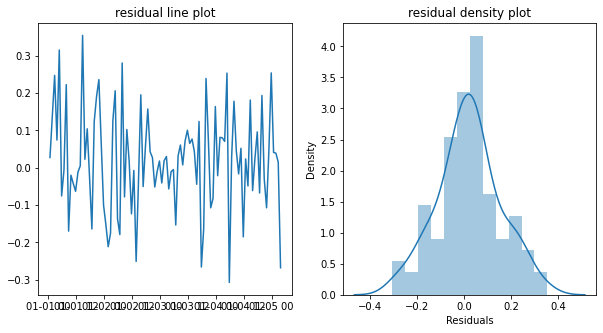

count    100.000000
mean       0.019809
std        0.133431
min       -0.307438
25%       -0.052934
50%        0.023102
75%        0.085119
max        0.354699
Name: Residuals, dtype: float64

In [239]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(ARIMA.Residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(ARIMA.Residuals)
ax2.set_title("residual density plot")
plt.show()
ARIMA.Residuals.describe()

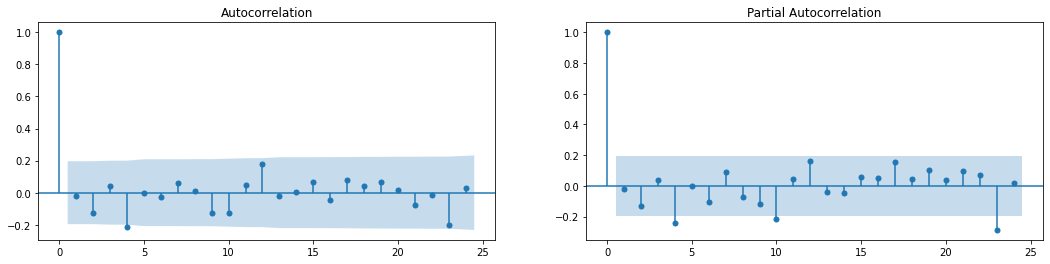

In [240]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(ARIMA.Residuals, lags=24, ax=ax1)
ax2 = plot_pacf(ARIMA.Residuals, lags=24, ax=ax2)

#### With seasonality (SARIMAX)

In [247]:
P, D, Q, s = 1,0,1,24
seasonality = pd.DataFrame(seasonal_decompose(df).seasonal)
seasonality.columns = ['swh']

In [248]:
seasonality2 = seasonality.copy()
seasonality2.head()

,swh
date,
2013-03-31 23:50:00,-0.018987
2013-04-01 00:50:00,-0.017050
2013-04-01 01:50:00,-0.019276
2013-04-01 02:50:00,-0.012658
2013-04-01 03:50:00,-0.004338


In [249]:
seasonality_ar = AutoRegressiveSeasonality(P, seasonality2, s)

In [250]:
seasonality_ar_pred = seasonality_ar.predict()

RMSE: 4.4416777844060374e-17 with 1 seasonal lags.
MAE: 3.848700871889044e-17 with 1 seasonal lags.


In [251]:
seasonality_ar_pred.head()

,Actual,Predicted
date,,
2016-01-01 00:50:00,-0.017050,-0.017050
2016-01-01 01:50:00,-0.019276,-0.019276
2016-01-01 02:50:00,-0.012658,-0.012658
2016-01-01 03:50:00,-0.004338,-0.004338
2016-01-01 04:50:00,-0.006332,-0.006332


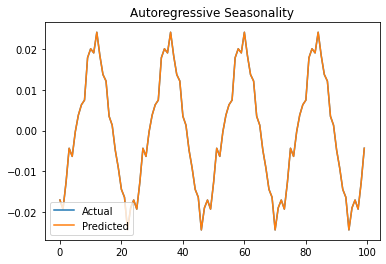

In [252]:
seasonality_ar.plot_predict()

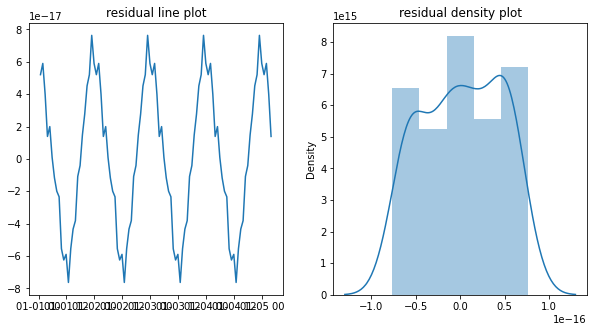

Statistics:
                  0
count  1.000000e+02
mean   1.658829e-18
std    4.460940e-17
min   -7.632783e-17
25%   -3.816392e-17
50%    9.215718e-19
75%    4.510281e-17
max    7.632783e-17


In [253]:
seasonality_ar.plot_residuals()

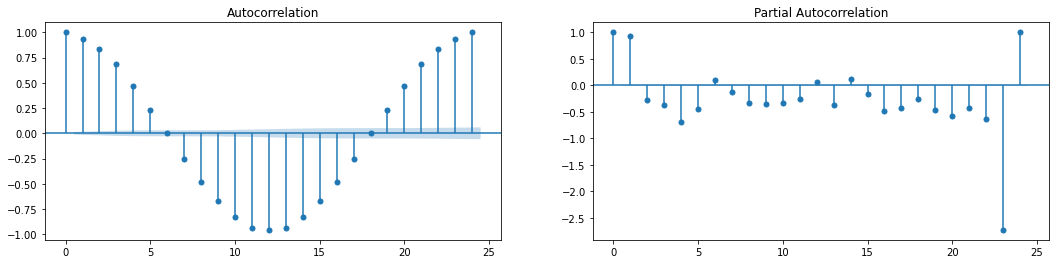

In [254]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(seasonality_ar.get_all_residuals().Residuals, lags=24, ax=ax1)
ax2 = plot_pacf(seasonality_ar.get_all_residuals().Residuals, lags=24, ax=ax2)

In [255]:
seasonality_resid = seasonality_ar.get_all_residuals()
seasonality_resid.head()

,Actual,Predicted,Residuals
date,,,
2013-04-01 23:50:00,-0.018987,-0.018987,5.898060e-17
2013-04-02 00:50:00,-0.017050,-0.017050,5.204170e-17
2013-04-02 01:50:00,-0.019276,-0.019276,5.898060e-17
2013-04-02 02:50:00,-0.012658,-0.012658,3.989864e-17
2013-04-02 03:50:00,-0.004338,-0.004338,1.387779e-17


In [256]:
seasonality_ma = MASeasonality(q, Q, seasonality_resid[['Residuals']], s)

In [257]:
seasonality_ma_pred = seasonality_ma.predict(100)

RMSE: 1.5047405205124837e-30 with 1 seasonal lags.
MAE: 1.3032382747679548e-30 with 1 seasonal lags.


In [258]:
seasonality_ma_pred.head()

,Residuals,Predicted
date,,
2016-01-01 00:50:00,5.204170e-17,5.204170e-17
2016-01-01 01:50:00,5.898060e-17,5.898060e-17
2016-01-01 02:50:00,3.989864e-17,3.989864e-17
2016-01-01 03:50:00,1.387779e-17,1.387779e-17
2016-01-01 04:50:00,1.994932e-17,1.994932e-17


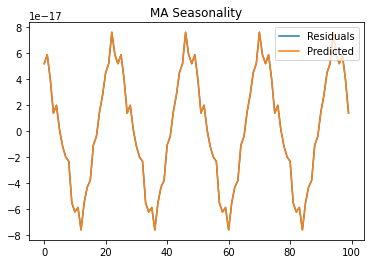

In [259]:
seasonality_ma.plot_predict()

#### Final Results (SARIMAX)

In [260]:
seasonality_pred = seasonality_ar_pred['Predicted'] + seasonality_ma_pred['Predicted'].values

In [261]:
SARIMAX = pd.DataFrame([ARIMA['Actual'].values,
                        ARIMA.Predicted.values + seasonality_pred.values,
                        ARIMA['Actual'].values-(ARIMA.Predicted.values + seasonality_pred.values)]).T
SARIMAX.columns = ['Actual', 'Predicted', 'Residuals']
SARIMAX.index = ARIMA.index

In [262]:
SARIMAX.head()

,Actual,Predicted,Residuals
date,,,
2016-01-01 00:50:00,2.59,2.545641,0.044359
2016-01-01 01:50:00,2.71,2.552990,0.157010
2016-01-01 02:50:00,2.88,2.619804,0.260196
2016-01-01 03:50:00,2.83,2.751525,0.078475
2016-01-01 04:50:00,3.11,2.788248,0.321752


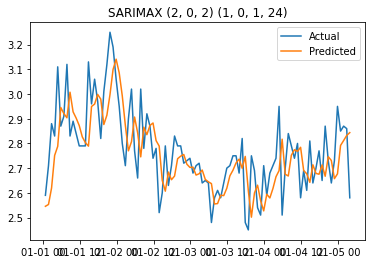

RMSE: 0.13594016883386817
MAE: 0.10550316994429206


In [263]:
plt.plot(SARIMAX.Actual, label='Actual')
plt.plot(SARIMAX.Predicted, label='Predicted')
plt.title(f'SARIMAX ({p}, {d}, {q}) ({P}, {D}, {Q}, {s})')
plt.legend()
plt.show()
print(f"RMSE: {np.sqrt(mean_squared_error(SARIMAX.Actual, SARIMAX.Predicted))}")
print(f"MAE: {mean_absolute_error(SARIMAX.Actual, SARIMAX.Predicted)}")

### Using modules

In [264]:
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm # auto arima
# from sklearn.model_selection import TimeSeriesSplit

#### Autoregressive

In [265]:
def AutoRegressiveModel(train_data, test_data, lags, steps):
    """
    Autoregression using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()
    residuals = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = AutoReg(history, lags=lags).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    return predictions, metrics

In [266]:
ar_predictions, ar_metrics = AutoRegressiveModel(train.swh.values, test.swh.values, 2, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.26it/s]


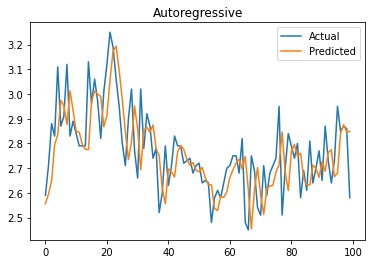

RMSE of AR: 0.1379045749967391
MAE of AR: 0.10378789037768532


In [267]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(ar_predictions, label="Predicted")
plt.title('Autoregressive')
plt.legend()
plt.show()
print(f"RMSE of AR: {ar_metrics[0]}")
print(f"MAE of AR: {ar_metrics[1]}")

#### ARIMA

In [268]:
def ArimaModel(train_data, test_data, arima_order: tuple, steps):
    """
    Arima using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = ARIMA(history, order=arima_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    
    return predictions, metrics

In [269]:
pdq = (2,0,2)
arima_predictions, arima_metrics = ArimaModel(train.swh.values, test.swh.values, pdq, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [22:00<00:00, 13.21s/it]


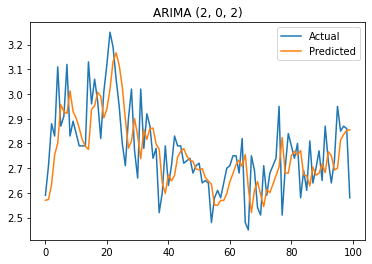

RMSE of ARIMA: 0.13425719680926473
MAE of ARIMA: 0.10404704528176804


In [270]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.title(f'ARIMA {pdq}')
plt.legend()
plt.show()
print(f"RMSE of ARIMA: {arima_metrics[0]}")
print(f"MAE of ARIMA: {arima_metrics[1]}")

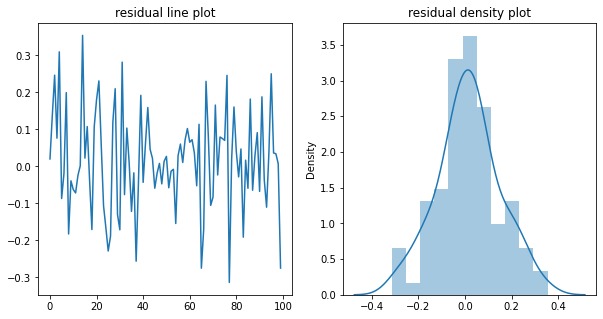

,0
count,100.000000
mean,0.014864
std,0.134104
min,-0.313774
25%,-0.060171
50%,0.018243
75%,0.082235
max,0.353991


In [271]:
residuals = pd.DataFrame(test.swh.values[:100] - arima_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

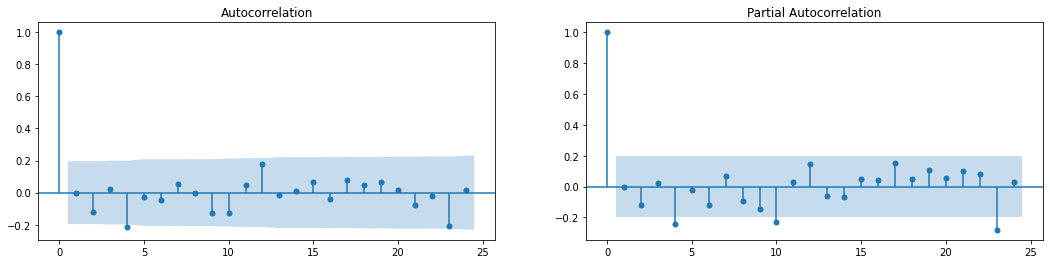

In [272]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(residuals, lags=24, ax=ax1)
ax2 = plot_pacf(residuals, lags=24, ax=ax2)

#### Arima Model 2 (include predicted data to forecast)

In [274]:
def ArimaModel2(train_data, test_data, arima_order: tuple, steps):
    """
    Arima using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = ARIMA(history, order=arima_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    
    return predictions, metrics

In [275]:
pdq = (2,0,2)
arima_predictions, arima_metrics = ArimaModel2(train.swh.values, test.swh.values, pdq, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:10<00:00, 12.10s/it]


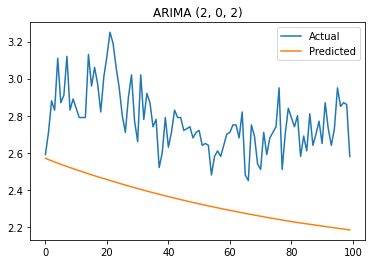

RMSE of ARIMA: 0.45473535211658705
MAE of ARIMA: 0.43047112040366514


In [276]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.title(f'ARIMA {pdq}')
plt.legend()
plt.show()
print(f"RMSE of ARIMA: {arima_metrics[0]}")
print(f"MAE of ARIMA: {arima_metrics[1]}")

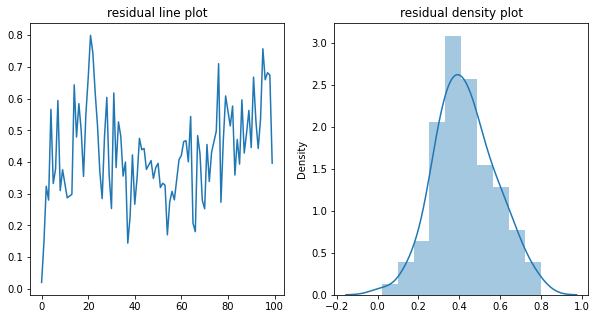

,0
count,100.000000
mean,0.430471
std,0.147295
min,0.019996
25%,0.332006
50%,0.421679
75%,0.527659
max,0.799719


In [277]:
residuals = pd.DataFrame(test.swh.values[:100] - arima_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

#### SARIMAX

In [273]:
def SarimaxModel(train_data, test_data, arima_order, seasonal_order, steps):
    history = [x for x in train_data]
    predictions = list()

    for t in tqdm(range(len(test_data[:steps]))):
        model = sm.SARIMAX(history, order=arima_order, seasonal_order=seasonal_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    rmse = np.sqrt(mean_squared_error(test_data[:steps],predictions))
    mae = mean_absolute_error(test_data[:steps],predictions)
    
    metrics = (rmse, mae)
    
    return predictions, metrics

In [141]:
PDQs = (1,0,1,24)
sarimax_predictions, sarimax_metrics = SarimaxModel(train.swh.values, test.swh.values, pdq, PDQs, 100)

In [ ]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(sarimax_predictions, label="Predicted")
plt.title(f'SARIMAX {pqd}{PDQs}')
plt.legend()
plt.show()
print(f"RMSE of ARIMA: {sarimax_metrics[0]}")
print(f"MAE of ARIMA: {sarimax_metrics[1]}")

In [ ]:
sarimax_residuals = pd.DataFrame(test.swh.values[:100] - sarimax_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(sarimax_residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(sarimax_residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(sarimax_residuals, lags=24, ax=ax1)
ax2 = plot_pacf(sarimax_residuals, lags=24, ax=ax2)

Search for the best fit parameter

In [17]:
# def GridArimaModel(train_data, test_data, p_values: list, d_values: list, q_values: list, steps):
#     """
#     Best fit Arima using walk forward validation
#     """
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     _, metrics = ArimaModel(train_data, test_data, (p,d,q), steps)
#                     if metrics[0] < best_score:
#                         best_score, best_cfg = metrics, order
#                 except:
#                     continue

#     predictions, metrics = ArimaModel(train_data, test_data, best_cfg, steps)

#     return predictions, best_cfg, best_score

In [22]:
# best_prediction, best_cfg, best_score = GridArimaModel(train.swh.values, test.swh.values,list(range(1,3)), [0], [1], 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


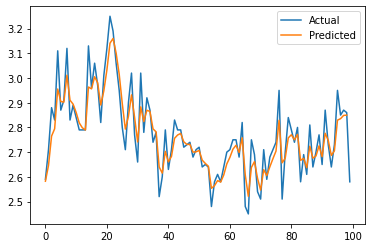

Best parameter of order: (1, 0, 1)
MSE of ARIMA: 0.0038912259457331453


In [23]:
# plt.plot(test.swh.values[:100], label="Actual")
# plt.plot(best_prediction, label="Predicted")
# plt.legend()
# plt.show()
# print(f"Best parameter of order: {best_cfg}")
# print(f"RMSE of ARIMA: {best_score[0]}")
# print(f"MAE of ARIMA: {best_score[1]}")

----